In [118]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from datetime import datetime
import cv2

In [119]:
T = 1000
max_noise = 0.02

betas = torch.linspace(0.001, max_noise, T)
alphas = 1-betas
alphas_cp = torch.cumprod(alphas, dim=0)

In [120]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
val_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=True)

# Part 4: The Sampling Process (The Reverse Step)

To generate an image, we don't just "guess $x_0$" in one go. Instead, we perform a "Reverse Dance" from $t = T$ down to $t = 0$. In each step, we move slightly from the noisy $x_t$ toward a cleaner $x_{t-1}$.

### The DDPM Step Formula
According to the original paper (Ho et al.), the update rule to find the previous state $x_{t-1}$ is:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \hat{\epsilon}_\theta(x_t, t) \right) + \sigma_t z$$

Where:
* $\hat{\epsilon}_\theta$: The noise predicted by our model.
* $z$: Standard Gaussian noise ($\sim \mathcal{N}(0, I)$) added back to keep the process stochastic (only for $t > 0$).
* $\sigma_t$: The variance of the step (often set to $\sqrt{\beta_t}$).

tensor(863)


Text(0.5, 1.0, '$hat_{X_o}$')

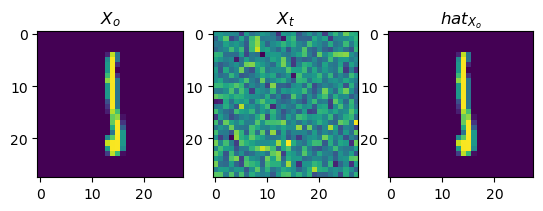

In [137]:
def generate_noised_img(x0: torch.Tensor, t: torch.Tensor):
    eps = torch.randn_like(x0)
    alpha_cp = alphas_cp[t.int().flatten()]
    xt = torch.sqrt(alpha_cp)[:, None, None, None] * x0 + torch.sqrt(1 - alpha_cp)[:, None, None, None] * eps

    return xt, eps


def denoise_img(xt: torch.Tensor, t: torch.Tensor, eps: torch.Tensor) -> torch.Tensor:
    if len(xt.shape) != 4:
        raise Exception(f"Expected Xt of shape B x C x H x W, got {xt.shape}")
    alpha_cp = alphas_cp[t.int().flatten()]
    return 1 / torch.sqrt(alpha_cp)[:, None, None, None] * (xt - torch.sqrt(1 - alpha_cp)[:, None, None, None] * eps)
    
def step_back(xt: torch.Tensor, t: torch.Tensor, eps_pred: torch.Tensor) -> torch.Tensor:
    if len(xt.shape) != 4:
        raise Exception(f"Expected Xt of shape B x C x H x W, got {xt.shape}")
        
    t = t.int().flatten()
    alpha = alphas[t][:, None, None, None]
    alpha_cp = alphas_cp[t][:, None, None, None]
    res = (1/torch.sqrt(alpha)) * (xt - (1-alpha) / torch.sqrt(1-alpha_cp) * eps_pred)
    
    if t <= 0:
        return res
    
    z = torch.randn_like(xt)
    std = torch.sqrt(betas[t])[:, None, None, None]
    return res + z * std


dummy_batch_x0, dummy_batch_labels = next(iter(train_loader))  # (B x 1 x 28 x 28), (B,)

t = torch.randint(0, T, size=(dummy_batch_x0.shape[0],))
dummy_batch_xt, dummy_batch_eps = generate_noised_img(dummy_batch_x0, t)
print(t[0])

denoised_img = denoise_img(dummy_batch_xt, t, dummy_batch_eps)

plt.subplot(131)
plt.imshow(dummy_batch_x0[0][0])
plt.title("$X_o$")

plt.subplot(132)
plt.imshow(dummy_batch_xt[0][0])
plt.title("$X_t$")

plt.subplot(133)
plt.imshow(denoised_img[0][0])
plt.title("$hat_{X_o}$")

In [122]:
img_sz = 28
flatten_size = img_sz * img_sz
p_dropout = 0.3


class DiffuserModel(nn.Module):
    def __init__(self):
        super().__init__()

        feats_in = flatten_size + 64
        self.t_expander = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )

        self.encoder = nn.Sequential(
            nn.Linear(feats_in, 256),  # input is 784 + 196 = 980
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            #
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        self.bottleneck = nn.Linear(128, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            #
            nn.Linear(256, flatten_size),
        )

        self.head = nn.Sequential(
            nn.Linear(flatten_size, flatten_size),
            nn.BatchNorm1d(flatten_size),
            nn.ReLU(),
            nn.Linear(flatten_size, flatten_size),
        )

    def forward(self, xt: torch.Tensor, t: torch.Tensor):
        xt = xt.flatten(start_dim=1)
        t_expanded = self.t_expander(t)

        concated = torch.concat((xt, t_expanded), dim=1)

        encoded = self.encoder(concated)
        encoded = self.bottleneck(encoded)
        decoded = self.decoder(encoded)
        
        eps = self.head(decoded + xt)

        return eps


dummy = torch.rand(size=(3, 28, 28))
dummy_t = torch.randint(low=0, high=T, size=(3, 1), dtype=torch.float32)
model = DiffuserModel()
model(dummy, dummy_t)

tensor([[-0.3004,  0.8802, -0.6508,  ...,  0.3554,  0.2731,  0.5045],
        [-0.1641, -0.2791, -0.5843,  ...,  0.0822,  0.5525, -0.5086],
        [-0.1034,  0.3087, -0.1695,  ..., -0.1911,  0.4979, -0.2535]],
       grad_fn=<AddmmBackward0>)

In [123]:
run_name = datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter()
writer.add_graph(model, [dummy, dummy_t])
writer.close()

In [124]:
avg_train_losses = []
avg_val_losses = []

In [125]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [126]:
epochs = 5
grad_acumm_steps = 40

for epoch in range(epochs):
    avg_train_loss = 0

    model.train()
    train_bar = tqdm(train_loader, desc="Training")
    for i, (x0, label) in enumerate(train_bar):
        t = torch.randint(low=0, high=T, size=(x0.shape[0],), dtype=torch.float32)
        xt, eps = generate_noised_img(x0, t)

        eps_pred = model(xt, t.view(-1, 1))

        loss = criterion(eps_pred, eps.flatten(start_dim=1))
        avg_train_loss += loss.item()
        loss.backward()

        if (i + 1) % grad_acumm_steps == 0:
            opt.step()
            opt.zero_grad()

        train_bar.set_postfix(loss=avg_train_loss / (i + 1))

    avg_train_loss /= len(train_loader)
    with torch.no_grad():
        avg_val_loss = 0
        model.eval()
        val_bar = tqdm(val_loader, desc="Validation")
        for i, (x0, label) in enumerate(val_bar):
            t = torch.randint(low=0, high=T, size=(x0.shape[0],), dtype=torch.float32)
            xt, eps = generate_noised_img(x0, t)

            eps_pred = model(xt, t.view(-1, 1))

            loss = criterion(eps_pred, eps.flatten(start_dim=1))
            avg_val_loss += loss.item()

            val_bar.set_postfix(loss=avg_val_loss / (i + 1))

        avg_val_loss /= len(val_loader)

    avg_train_losses.append(avg_train_loss)
    avg_val_losses.append(avg_val_loss)

    print(f"EPOCH {epoch} | avg train loss {avg_train_loss:.2f} | avg val loss {avg_val_loss:.2f}")

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 0 | avg train loss 0.81 | avg val loss 0.61


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 1 | avg train loss 0.54 | avg val loss 0.45


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 2 | avg train loss 0.42 | avg val loss 0.36


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 3 | avg train loss 0.36 | avg val loss 0.31


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

EPOCH 4 | avg train loss 0.33 | avg val loss 0.29


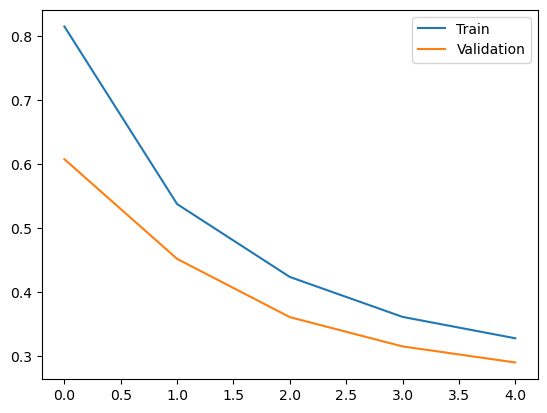

In [127]:
plt.plot(avg_train_losses, label="Train")
plt.plot(avg_val_losses, label="Validation")
plt.legend()

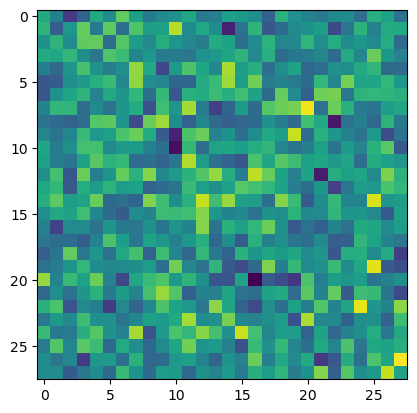

In [145]:
model.eval()
img = torch.randn((1, 1, 28, 28))

for t in range(T - 1, -1, -1):
    t_tensor = torch.tensor([[t]], dtype=torch.float32)
    pred_noise = model(img, t_tensor)
    pred_noise = pred_noise.view(-1, 1, 28, 28)
    
    img = step_back(img, t_tensor, pred_noise)
    
    if t % 20 == 0:
        img_np = img.flatten(0, 2).detach().numpy()
        img_np = np.clip(img_np, 0, 1)
        img_np = cv2.resize(img_np, (240, 240))
        cv2.imshow("hoho", img_np)
        plt.show()
        if cv2.waitKey(1) == ord('q'):
            cv2.destroyAllWindows()
            break
        
cv2.destroyAllWindows()


plt.imshow(img[0][0].detach().numpy())